In [1]:
from collections import defaultdict
import os, urllib.request

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn, sklearn.model_selection, sklearn.linear_model

from projection_simplex_vectorized import projection_simplex
from postprocess import PostProcessorDP
import utils

split_ratio_for_postprocessing = 0.5

seed = 33
rng = np.random.default_rng(seed)
bw = 1 / 1000
n_perturbations_train = 10
n_perturbations_eval = 1000

## Download and pre-process UCI Communities and Crime dataset

In [2]:
features = [
    "state", "county", "community", "communityname", "fold", "population",
    "householdsize", "racepctblack", "racePctWhite", "racePctAsian",
    "racePctHisp", "agePct12t21", "agePct12t29", "agePct16t24", "agePct65up",
    "numbUrban", "pctUrban", "medIncome", "pctWWage", "pctWFarmSelf",
    "pctWInvInc", "pctWSocSec", "pctWPubAsst", "pctWRetire", "medFamInc",
    "perCapInc", "whitePerCap", "blackPerCap", "indianPerCap", "AsianPerCap",
    "OtherPerCap", "HispPerCap", "NumUnderPov", "PctPopUnderPov",
    "PctLess9thGrade", "PctNotHSGrad", "PctBSorMore", "PctUnemployed",
    "PctEmploy", "PctEmplManu", "PctEmplProfServ", "PctOccupManu",
    "PctOccupMgmtProf", "MalePctDivorce", "MalePctNevMarr", "FemalePctDiv",
    "TotalPctDiv", "PersPerFam", "PctFam2Par", "PctKids2Par",
    "PctYoungKids2Par", "PctTeen2Par", "PctWorkMomYoungKids", "PctWorkMom",
    "NumIlleg", "PctIlleg", "NumImmig", "PctImmigRecent", "PctImmigRec5",
    "PctImmigRec8", "PctImmigRec10", "PctRecentImmig", "PctRecImmig5",
    "PctRecImmig8", "PctRecImmig10", "PctSpeakEnglOnly", "PctNotSpeakEnglWell",
    "PctLargHouseFam", "PctLargHouseOccup", "PersPerOccupHous",
    "PersPerOwnOccHous", "PersPerRentOccHous", "PctPersOwnOccup",
    "PctPersDenseHous", "PctHousLess3BR", "MedNumBR", "HousVacant",
    "PctHousOccup", "PctHousOwnOcc", "PctVacantBoarded", "PctVacMore6Mos",
    "MedYrHousBuilt", "PctHousNoPhone", "PctWOFullPlumb", "OwnOccLowQuart",
    "OwnOccMedVal", "OwnOccHiQuart", "RentLowQ", "RentMedian", "RentHighQ",
    "MedRent", "MedRentPctHousInc", "MedOwnCostPctInc", "MedOwnCostPctIncNoMtg",
    "NumInShelters", "NumStreet", "PctForeignBorn", "PctBornSameState",
    "PctSameHouse85", "PctSameCity85", "PctSameState85", "LemasSwornFT",
    "LemasSwFTPerPop", "LemasSwFTFieldOps", "LemasSwFTFieldPerPop",
    "LemasTotalReq", "LemasTotReqPerPop", "PolicReqPerOffic", "PolicPerPop",
    "RacialMatchCommPol", "PctPolicWhite", "PctPolicBlack", "PctPolicHisp",
    "PctPolicAsian", "PctPolicMinor", "OfficAssgnDrugUnits",
    "NumKindsDrugsSeiz", "PolicAveOTWorked", "LandArea", "PopDens",
    "PctUsePubTrans", "PolicCars", "PolicOperBudg", "LemasPctPolicOnPatr",
    "LemasGangUnitDeploy", "LemasPctOfficDrugUn", "PolicBudgPerPop",
    "ViolentCrimesPerPop"
]

data_path = "data/communities/communities.data"
if not os.path.exists(data_path):
  os.makedirs("data/communities", exist_ok=True)
  urllib.request.urlretrieve(
      "https://archive.ics.uci.edu/ml/machine-learning-databases/communities/communities.data",
      data_path)

original = pd.read_csv(data_path,
                       names=features,
                       sep=r",",
                       engine="python",
                       na_values="?")

# Drop community name, state, and county, and columns with missing values
original = original.drop(["communityname", "state", "county"],
                         axis=1).dropna(axis=1)

In [3]:
def data_transform(df):
  """Normalize features."""
  binary_data = pd.get_dummies(df)
  scaler = sklearn.preprocessing.StandardScaler()
  data = pd.DataFrame(scaler.fit_transform(binary_data),
                      columns=binary_data.columns)
  data.index = df.index
  return data


# Create 5 equidistance bins for ViolentCrimesPerPop column
labels_original = pd.cut(original["ViolentCrimesPerPop"], 5)

# Get sensitive attributes
minority_pct = np.stack([
    original[a].to_numpy()
    for a in ["racePctHisp", "racePctAsian", "racepctblack"]
],
                        axis=1)
minority_presence = np.array(["hispanic", "asian",
                              "black"])[minority_pct.argmax(axis=1)]
minority_presence[original["racePctWhite"] > 0.95] = "white"
original["MinorityPresence"] = minority_presence

label_names, labels = np.unique(labels_original, return_inverse=True)
n_classes = len(label_names)

data = original.copy()
data = data.drop(["ViolentCrimesPerPop", "fold"], axis=1)
data = data_transform(data)

In [4]:
# Define some utility functions


def get_group_labels_and_print_statistics(sensitive_attributes):

  df = original.copy()
  df["Target"] = np.array(label_names)[labels]
  groups = original[sensitive_attributes[0]]
  for attribute in sensitive_attributes[1:]:
    groups = np.add(np.add(groups, ", "), original[attribute])
  df["Group"] = groups
  df_grouped = df.groupby(["Target", "Group"]).size().unstack()
  counts = df_grouped.sum(axis=0)

  group_names, groups = np.unique(groups, return_inverse=True)
  n_groups = len(group_names)
  n_classes = len(df_grouped.index)

  print("Dataset statistics:")
  display(df_grouped / counts)
  display(pd.DataFrame(counts, columns=["Count"]).T)

  print()
  print("Perfect results if dataset equals population:")
  display(
      pd.DataFrame({
          "group_balanced_err": {
              "no_postprocess":
                  0.0,
              "postprocess":
                  PostProcessorDP().fit(
                      np.concatenate(
                          [np.eye(n_classes) for _ in range(n_groups)], axis=0),
                      np.repeat(np.arange(n_groups), n_classes),
                      p=np.nan_to_num((df_grouped.to_numpy() /
                                       counts.to_numpy())).T.flatten()).score_
          },
          "dp_gap": {
              "no_postprocess": utils.dp_gap(labels, groups),
              "postprocess": 0.0
          }
      }))

  return groups, n_groups


def add_metrics_to_dict(dictionary, model_name, fold, test_labels, test_preds,
                        test_groups, n_groups):
  dictionary["group_balanced_err"][model_name][fold] = utils.error_rate(
      test_labels,
      test_preds,
      test_groups,
      w=np.ones(n_groups) / n_groups,
      n_groups=n_groups)
  dictionary["dp_gap"][model_name][fold] = utils.dp_gap(test_preds,
                                                        test_groups,
                                                        n_classes=n_classes,
                                                        n_groups=n_groups)


def plot_results(alpha, res, title):
  fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
  ax.scatter([list(res["group_balanced_err"].values())[0]],
             [list(res["dp_gap"].values())[0]],
             c="w",
             edgecolors="k",
             zorder=3)
  sc = ax.scatter(list(res["group_balanced_err"].values())[1:],
                  list(res["dp_gap"].values())[1:],
                  c=alpha,
                  zorder=2)
  cbar = fig.colorbar(sc, ax=ax, label="$\\alpha$")
  ax.set_xlabel("Group-balanced error")
  ax.set_ylabel("$\\Delta_{\\mathrm{DP}}$")
  ax.set_title(title)
  ax.grid(True, which="both", zorder=0)
  plt.show()

In [5]:
sensitive_attributes = ["MinorityPresence"]
groups, n_groups = get_group_labels_and_print_statistics(sensitive_attributes)

Dataset statistics:


Group,asian,black,hispanic,white
Target,,,,
"(-0.001, 0.2]",0.768683,0.340625,0.417323,0.922141
"(0.2, 0.4]",0.156584,0.279687,0.367454,0.060827
"(0.4, 0.6]",0.032028,0.185938,0.131234,0.012165
"(0.6, 0.8]",0.028470,0.092188,0.049869,0.002433
"(0.8, 1.0]",0.014235,0.101562,0.034121,0.002433


Group,asian,black,hispanic,white
Count,562,640,381,411



Perfect results if dataset equals population:


,group_balanced_err,dp_gap
no_postprocess,0.000000,0.581516
postprocess,0.233219,0.000000


## Post-process

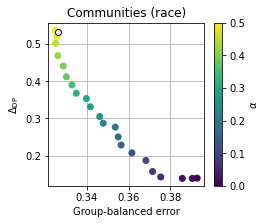

,group_balanced_err,dp_gap
no_postprocess,0.326356,0.532059
0.5,0.324725,0.536031
0.48,0.325479,0.521021
0.45,0.324978,0.501278
0.42,0.326050,0.467889
0.4,0.328677,0.440182
0.38,0.330138,0.411467
0.35,0.332803,0.389746
0.32,0.334882,0.367285
0.3,0.339759,0.353136


In [6]:
# Save q_by_group under alpha=0 for smoothing experiments in next cell
q_by_fold_and_group = []

res_by_fold = defaultdict(lambda: defaultdict(dict))
alphas = [
    0.5, 0.48, 0.45, 0.42, 0.4, 0.38, 0.35, 0.32, 0.3, 0.28, 0.25, 0.22, 0.2,
    0.18, 0.15, 0.12, 0.1, 0.08, 0.05, 0.02, 0.01, 0.0
]

for fold in original["fold"].unique():

  train_data = data[original["fold"] != fold]
  train_labels = labels[original["fold"] != fold]
  train_groups = groups[original["fold"] != fold]
  test_data = data[original["fold"] == fold]
  test_labels = labels[original["fold"] == fold]
  test_groups = groups[original["fold"] == fold]

  # Train data split
  train_data_pre, train_data_post, train_labels_pre, train_labels_post, train_groups_pre, train_groups_post = sklearn.model_selection.train_test_split(
      train_data,
      train_labels,
      train_groups,
      test_size=split_ratio_for_postprocessing,
      random_state=seed)
  train_labels_pre_one_hot = pd.get_dummies(train_labels_pre)

  predictor = sklearn.linear_model.LinearRegression()
  predictor.fit(train_data_pre, train_labels_pre_one_hot)
  train_probas_post = projection_simplex(predictor.predict(train_data_post),
                                         axis=1)
  test_probas = projection_simplex(predictor.predict(test_data), axis=1)

  add_metrics_to_dict(res_by_fold, "no_postprocess", fold, test_labels,
                      np.argmax(test_probas, axis=1), test_groups, n_groups)
  for alpha in alphas:
    postprocessor = PostProcessorDP().fit(train_probas_post,
                                          train_groups_post,
                                          alpha=alpha)
    test_preds = postprocessor.predict(test_probas, test_groups)
    add_metrics_to_dict(res_by_fold, alpha, fold, test_labels, test_preds,
                        test_groups, n_groups)

    if alpha == 0.0:
      q_by_fold_and_group.append(postprocessor.q_by_group_)

res = {
    k: {k2: np.mean(list(v2.values())) for k2, v2 in v.items()
       } for k, v in res_by_fold.items()
}

plot_results(alphas, res, "Communities (race)")
display(pd.DataFrame(res))

In [7]:
res_by_fold = defaultdict(lambda: defaultdict(dict))
alphas = [0.0]

for fold in original["fold"].unique():

  train_data = data[original["fold"] != fold]
  train_labels = labels[original["fold"] != fold]
  train_groups = groups[original["fold"] != fold]
  test_data = data[original["fold"] == fold]
  test_labels = labels[original["fold"] == fold]
  test_groups = groups[original["fold"] == fold]

  # Train data split
  train_data_pre, train_data_post, train_labels_pre, train_labels_post, train_groups_pre, train_groups_post = sklearn.model_selection.train_test_split(
      train_data,
      train_labels,
      train_groups,
      test_size=split_ratio_for_postprocessing,
      random_state=seed)
  train_labels_pre_one_hot = pd.get_dummies(train_labels_pre)

  predictor = sklearn.linear_model.LinearRegression()
  predictor.fit(train_data_pre, train_labels_pre_one_hot)
  train_probas_post = projection_simplex(predictor.predict(train_data_post),
                                         axis=1)
  test_probas = projection_simplex(predictor.predict(test_data), axis=1)

  train_probas_post = utils.perturb(rng,
                                    train_probas_post,
                                    bw=bw,
                                    repeat=n_perturbations_train)
  train_labels_post = np.repeat(train_labels_post, n_perturbations_train)
  train_groups_post = np.repeat(train_groups_post, n_perturbations_train)

  test_probas_perturbed = utils.perturb(rng,
                                        test_probas,
                                        bw=bw,
                                        repeat=n_perturbations_eval)
  test_labels_repeated = np.repeat(test_labels, n_perturbations_eval)
  test_groups_repeated = np.repeat(test_groups, n_perturbations_eval)

  for alpha in alphas:
    postprocessor = PostProcessorDP().fit(train_probas_post,
                                          train_groups_post,
                                          alpha=alpha,
                                          q_by_group=q_by_fold_and_group[fold -
                                                                         1])
    test_preds = postprocessor.predict(test_probas, test_groups)
    add_metrics_to_dict(res_by_fold, alpha, fold, test_labels, test_preds,
                        test_groups, n_groups)

res = {
    k: {k2: np.mean(list(v2.values())) for k2, v2 in v.items()
       } for k, v in res_by_fold.items()
}

print("With smoothing:")
display(pd.DataFrame(res))

With smoothing:


,group_balanced_err,dp_gap
0.0,0.383645,0.116849
